### Test Ant Colony Optimization

In [1]:
import numpy as np
import osmnx as ox
import networkx as nx
from math import ceil

In [2]:
# print("Map is downloading and Graph is creating...")
# G = ox.graph_from_point((41.042915, 29.007339), distance=1000, network_type='drive')
# ox.save_graphml(G, filename='besiktas.graphml')
# print("Graph Saved")

In [3]:
# Create Graphml with using osmnx
Graphml = ox.load_graphml('besiktas.graphml')
print('The file is loaded, it is ready to use.')

The file is loaded, it is ready to use.


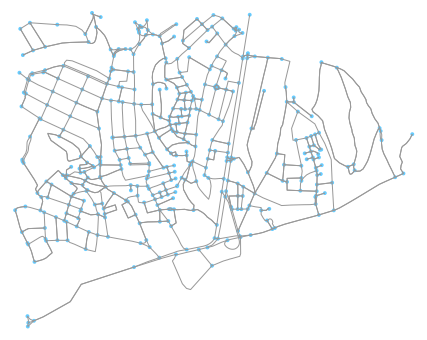

This map includes 423 nodes.
This map includes 919 edges.


In [4]:
ox.plot_graph(Graphml)
print('This map includes ' + str(len(Graphml.nodes)) + ' nodes.')
print('This map includes ' + str(len(Graphml.edges)) + ' edges.')

In [5]:
# Create our Graph with using Networkx
G = nx.DiGraph() 

In [6]:
# https://www.findlatitudeandlongitude.com/ 
# You can find latitude and longitude with using above link.

akaretler_nearest_point = ox.get_nearest_node(Graphml, (41.041442, 29.003669), method='haversine', return_dist=False)
print('Akaretler nearest point is: ' + str(akaretler_nearest_point))

abbasaga_nearest_point = ox.get_nearest_node(Graphml, (41.044801, 29.007473), method='haversine', return_dist=False)
print('Abbasaga nearest point is: ' + str(abbasaga_nearest_point))

Akaretler nearest point is: 269350455
Abbasaga nearest point is: 2385194439


In [7]:
# Add this to as source and target
G.add_node(akaretler_nearest_point, role = 'source')
G.add_node(abbasaga_nearest_point, role = 'target')

It is not necessary to add all nodes with their positions. You can comment the box below.

In [8]:
# Add all nodes with their positions
for node in Graphml.nodes:
    G.add_node(node, pos=(Graphml.nodes[node]['x'], Graphml.nodes[node]['y']))

The important part of this graph: Adding all edges one by one

In [9]:
# Add all edges with their weights
for edge in Graphml.edges.data():
    if(edge[2]['length'] != 0):
        G.add_edge(edge[0], edge[1], weight = edge[2]['length'])
    else:
        print(edge)

In [10]:
# We can see number of edges and nodes

print('This graph has ' + str(G.number_of_nodes()) + ' nodes.')
print('This graph has ' + str(G.number_of_edges()) + ' edges.')

# for edge in G.edges.data():
#     if(edge[2]['weight'] == 0):
#         print(edge)

This graph has 423 nodes.
This graph has 908 edges.


Below drawing takes a lot of time because of more than 500 thousands edges and nodes.

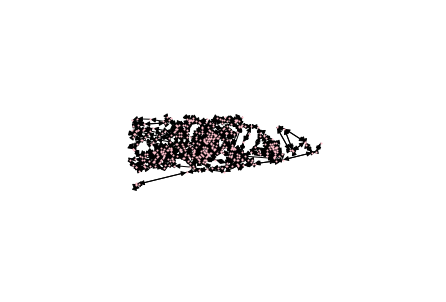

In [11]:
# Plot Nodes
_ = nx.draw(G, pos=nx.get_node_attributes(G, 'pos'), node_size=1, alpha = 1, node_color='pink', with_labels=False)

So, We can draw with using osmnx library which takes less time comparing the one that above.

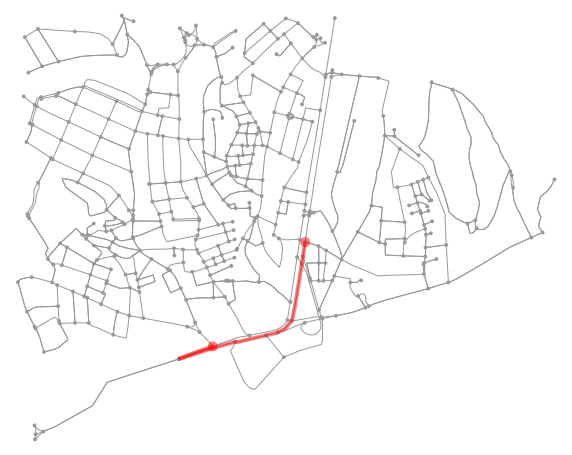

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a205d7690>)

In [12]:
ox.plot_graph_route(Graphml, nx.shortest_path(Graphml, akaretler_nearest_point, abbasaga_nearest_point, weight='length', method='dijkstra'), fig_height=10, fig_width=10)

In [13]:
print('Shortest path osmid ids: ')

sp = nx.shortest_path(Graphml, akaretler_nearest_point, abbasaga_nearest_point, weight='length', method='dijkstra')

length = 0
for i in range(len(sp)-1):
    length += G.edges[(sp[i], sp[i+1])]['weight']

print(sp)
print('The length is: '+ str(length))

Shortest path osmid ids: 
[269350455, 31681081, 269350362, 269350323, 2385194412, 31681091, 539096414, 503975639, 2385194439]
The length is: 833.477


In [14]:
class ant():
    def __init__(self, G, start = akaretler_nearest_point, end = abbasaga_nearest_point, alpha = 1, beta = 1):
        self.G = G
        self.current_city, self.target_city = start, end
        self.alpha, self.beta = alpha, beta
        self.route = {self.current_city : 0} 
        self.L = 0
        self.deleted = []
        
    def move(self):
        if self.current_city == self.target_city: return
        # Dont visit an-already-visited city
        possible_edges =[e for e in G.edges([self.current_city]) if e[1] not in self.route and e[1] not in self.deleted]
        possible_cities = [e[1] for e in possible_edges]
        
        distances = np.array([G.edges[e]['weight'] for e in possible_edges])
        pheremons = np.array([G.edges[e]['pheromone'] for e in possible_edges])
        
        preferences = pheremons**self.alpha/distances**self.beta
        probabilities = preferences/preferences.sum()
        
        if not possible_cities:
            deleted_item = self.route.popitem()
            self.deleted.append(deleted_item[0])
            self.L = self.L - self.G.edges[(list(self.route.keys())[-1], deleted_item[0])]['weight']
            self.current_city = list(self.route.keys())[-1]
            self.move()
        else:
            new_city = np.random.choice(a=possible_cities, size=1, p=probabilities)[0]
            self.L += self.G.edges[(self.current_city, new_city)]['weight']
            self.current_city = new_city
            self.route[self.current_city] = len(self.route)
        
    def go(self):
        for i in range(self.G.number_of_nodes()): 
            self.move()
            
    def get_path(self):
        inv_route = {v:k for k, v in self.route.items()}
        return [inv_route[i] for i in range(len(inv_route))]

In [15]:
class antcolony():
    def __init__(self, G, start = akaretler_nearest_point, end = abbasaga_nearest_point, alpha = 1, beta = 1):  
        self.G, eps = G, 0.0001
        nx.set_edge_attributes(self.G, eps, 'pheromone')
        self.start, self.end = start, end
        self.alpha, self.beta = alpha, beta
        
    def evaporation(self, decay = 0.05):
        # Evaporation of Pheromon
        phe = nx.get_edge_attributes(G, 'pheromone')
        new_phe = {k:v * (1 - decay) for k, v in phe.items()}
        nx.set_edge_attributes(self.G, new_phe, 'pheromone')
        
    def deposit(self, route, L, delta = 1):
        for i,j in zip(route[:-1], route[1:]):
            #self.G.edges[(i, j)]['pheromone'] +=  delta/ self.G.edges[(i, j)]['weight'] 
            self.G.edges[(i, j)]['pheromone'] +=  delta/ L
            
    def run(self, number_of_ants = 10, time = 20):
        # in each time step
        for t in range(time):
            # K ants exist in the colony
            self.colony = [ant(self.G, self.start, self.end, self.alpha, self.beta) 
                      for k in range(number_of_ants)]
            # distributed and paralel moves of K ants
            for k in range(number_of_ants): self.colony[k].go()
                
            # after independent moves, ants deposit pheremon
            for k in range(number_of_ants):
                self.deposit(route = self.colony[k].get_path(), 
                             L = self.colony[k].L)     
            self.evaporation()
            

In [16]:
swarm = antcolony(G, start = akaretler_nearest_point, end = abbasaga_nearest_point, alpha = 1, beta = 1)
swarm.run(number_of_ants = 500, time = 20)

In [17]:
# [(a.route, a.L) for a in swarm.colony]

In [18]:
shortest_path = 2000
for a in swarm.colony:
    if shortest_path > a.L:
        shortest_path = a.L
print(shortest_path)

932.1229999999999


In [19]:
print('The answer needs to be ' + str(length) + ', in our example we found as ' + str(shortest_path))

The answer needs to be 833.477, in our example we found as 932.1229999999999
